<a href="https://colab.research.google.com/github/kan1shq/modelZoo/blob/main/I3D_NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
labels_classify = ['Class 1','Class 2']

class_dict = {
    1:'Rope Climbing',2:'Glass Blowing'
}

In [ ]:
!pip install ray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset
import os
# import xlrd
import pandas as pd
import csv

import json

from torch.autograd import Variable
import torch
import torch.optim as optim
from datetime import datetime, timedelta
from torch.utils.data import DataLoader
import os
import math
import torch.nn as nn
import pdb

import imageio
# imageio.plugins.ffmpeg.download()
import torchvision.transforms.functional as functional
import torchvision.transforms as transforms
import torch
import numpy as np


import sys
import cv2
import math 
import tqdm
import glob
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from cv2 import VideoWriter, VideoWriter_fourcc

from scipy.io import loadmat
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from sklearn import preprocessing
import random

from torch.autograd import Variable
import torch
import torch.optim as optim
from datetime import datetime, timedelta
from torch.utils.data import DataLoader
import os
import math
import torch.nn as nn
import pdb

import torch
import torch.nn as nn
import torch.nn.functional as F
import toml

import glob
from matplotlib.pyplot import imshow, show 

import skimage
from skimage.color import rgb2gray
from skimage.registration import optical_flow_tvl1

import pickle

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [ ]:
os.chdir('drive/MyDrive/NNFL/kinetics400_tiny/kinetics400_tiny/')

In [ ]:
def make_csv(filepath):
  with open(filepath) as f:
    lines = f.readlines()

  try:
    my_csv = {}
    for i in range(len(lines)):
      lines[i] = lines[i][:-1]
      temp = lines[i].split(' ')
      my_csv[temp[0]] = int(temp[1])

   

    with open('initial_labels.csv', 'w') as f:  
        w = csv.DictWriter(f, my_csv.keys())
        w.writeheader()
        w.writerow(my_csv)

    initial_labels = pd.read_csv('labels.csv').transpose()
    initial_labels.reset_index(inplace=True)
    initial_labels.columns = ['Video', 'HotEncode']
    initial_labels.to_csv('labels.csv')
    return 'CSV Formed'

  except Exception as e:
    return e  

make_csv('kinetics_tiny.txt')

ValueError('Length mismatch: Expected axis has 41 elements, new values have 2 elements')

In [ ]:
labels_new = pd.read_csv('labels.csv')
labels_new.columns = ['Index', 'Video', 'HotEncode']
# labels_new.set_index('Index', inplace=False)
del labels_new['Index']
labels_new.head()

Video  HotEncode
0  D32_1gwq35E.mp4          0
1  iRuyZSKhHRg.mp4          1
2  oXy-e_P_cAI.mp4          0
3  34XczvTaRiI.mp4          1
4  h2YqqUhnR34.mp4          0

In [ ]:
import imageio
import cv2
import os
import numpy as np
imageio.plugins.ffmpeg.download()

SMALLEST_DIM = 256
IMAGE_CROP_SIZE = 224
FRAME_RATE = 25

# sample frames at 25 frames per second
def sample_video(video_path, path_output):
    # for filename in os.listdir(video_path):
    if video_path.endswith((".mp4", ".avi",".mkv")):
        # filename = video_path + filename
        os.system("ffmpeg -r {1} -i {0} -q:v 2 {2}/frame_%05d.jpg".format(video_path, FRAME_RATE,
                                                                          path_output))
    else:
        raise ValueError("Video path is not the name of video file (.mp4 or .avi)")


# the videos are resized preserving aspect ratio so that the smallest dimension is 256 pixels, with bilinear interpolation
def resize(img):
    # print('Original Dimensions : ', img.shape)

    original_width = int(img.shape[1])
    original_height = int(img.shape[0])

    aspect_ratio = original_width / original_height

    if original_height < original_width:
        new_height = SMALLEST_DIM
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = SMALLEST_DIM
        new_height = int(original_width / aspect_ratio)

    dim = (new_width, new_height)
    # resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
    # print('Resized Dimensions : ', resized.shape)

    return resized


def crop_center(img, new_size):
    y, x, c = img.shape
    (cropx, cropy) = new_size
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]


def rescale_pixel_values(img):
  
    img = img.astype('float32')
    img = (img / 255.0) * 2 - 1
    
    return img


# The provided .npy file thus has shape (1, num_frames, 224, 224, 3) for RGB, corresponding to a batch size of 1
def run_rgb(sorted_list_frames):
    result = np.zeros((1, IMAGE_CROP_SIZE, IMAGE_CROP_SIZE, 3))
    for full_file_path in sorted_list_frames:
        img = cv2.imread(full_file_path, cv2.IMREAD_UNCHANGED)
        img = pre_process_rgb(img)
        new_img = np.reshape(img, (1, IMAGE_CROP_SIZE, IMAGE_CROP_SIZE, 3))
        result = np.append(result, new_img, axis=0)

    result = result[1:, :, :, :]
    result = np.expand_dims(result, axis=0)
    return result


def pre_process_rgb(img):
    resized = resize(img)
    img_cropped = crop_center(resized, (IMAGE_CROP_SIZE, IMAGE_CROP_SIZE))
    img = rescale_pixel_values(img_cropped)
    return img


def read_frames(video_path):
    list_frames = []
    for file in os.listdir(video_path):
        if file.endswith(".jpg"):
            full_file_path = video_path + file
            list_frames.append(full_file_path)
    sorted_list_frames = sorted(list_frames)
    return sorted_list_frames


def run_flow(sorted_list_frames):
    sorted_list_img = []
    for frame in sorted_list_frames:
        img = cv2.imread(frame, cv2.IMREAD_UNCHANGED)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sorted_list_img.append(img_gray)

    result = np.zeros((1, IMAGE_CROP_SIZE, IMAGE_CROP_SIZE, 2))
    prev = sorted_list_img[0]
    for curr in sorted_list_img[1:]:
        flow = compute_optical_flow(prev, curr)
        flow = pre_process_flow(flow)
        prev = curr
        result = np.append(result, flow, axis=0)

    result = result[1:, :, :, :]
    result = np.expand_dims(result, axis=0)
    return result


def pre_process_flow(flow_frame):
    resized = resize(flow_frame)
    img_cropped = crop_center(resized, (IMAGE_CROP_SIZE, IMAGE_CROP_SIZE))
    new_img = np.reshape(img_cropped, (1, IMAGE_CROP_SIZE, IMAGE_CROP_SIZE, 2))
    return new_img


#  Pixel values are truncated to the range [-20, 20], then rescaled between -1 and 1
def compute_optical_flow(prev, curr):
    optical_flow = cv2.optflow.createOptFlow_DualTVL1()
    flow_frame = optical_flow.calc(prev, curr, None)
    flow_frame = np.clip(flow_frame, -20, 20)
    flow_frame = flow_frame / 20.0
    return flow_frame

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1155072/45929032 bytes (2.5%)4136960/45929032 bytes (9.0%)7462912/45929032 bytes (16.2%)10551296/45929032 bytes (23.0%)13844480/45929032 bytes (30.1%)17178624/45929032 bytes (37.4%)20537344/45929032 bytes (44.7%)23904256/45929032 bytes (52.0%)27222016/45929032 bytes (59.3%)30646272/45929032 bytes (66.7%)33808384/45929032 bytes (73.6%)37249024/45929032 bytes (81.1%)4

In [ ]:
from datetime import datetime, timedelta
import torch

num_classes = 2
num_frames = 16


def generate_frames(dir,split,mode):

    set_gen = 0

    for s in range(len(labels_new)):
      try:
        path = dir+'/'+ (labels_new['Video'][s])
        path_output = path[:-4] + '/'

        path = str(path)
        path_output = str(path_output)

        if not os.path.exists(path):
            print('lite lele', s)

            continue

        if not os.path.exists(path_output):
            os.makedirs(path_output)

        print(f"Generating frames for S{s}")
        sample_video(path,path_output)
        print("Done")

      except Exception as e:
        print(e)
        print(f"ERROR -- Generating frames for S{s}")
      
      set_gen = set_gen + 1

    pass

In [ ]:
generate_frames("./train",'train','rgb')

Generating frames for S0
Done
Generating frames for S1
Done
Generating frames for S2
Done
Generating frames for S3
Done
Generating frames for S4
Done
Generating frames for S5
Done
Generating frames for S6
Done
Generating frames for S7
Done
Generating frames for S8
Done
Generating frames for S9
Done
Generating frames for S10
Done
Generating frames for S11
Done
Generating frames for S12
Done
Generating frames for S13
Done
Generating frames for S14
Done
Generating frames for S15
Done
Generating frames for S16
Done
Generating frames for S17
Done
Generating frames for S18
Done
Generating frames for S19
Done
Generating frames for S20
Done
Generating frames for S21
Done
Generating frames for S22
Done
Generating frames for S23
Done
Generating frames for S24
Done
Generating frames for S25
Done
Generating frames for S26
Done
Generating frames for S27
Done
Generating frames for S28
Done
Generating frames for S29
Done
Generating frames for S30
Done
Generating frames for S31
Done
Generating frames 

In [ ]:
num_classes = 2
num_frames = 16
num_sub = 40

def make_dataset(dir,split,mode,save_dir):

        set_gen = 0
        id = 0

        ids = []
        name = []
        labels = []

        if not os.path.exists('./'+save_dir):
            os.makedirs('./'+save_dir)

        for s in range(1,num_sub+1):
          try:

            path = dir+'/'+ (labels_new['Video'][s-1])
            path_output = path[:-4] + '/'

            if not os.path.exists(path):
                continue

            vid = labels_new['Video'][s-1][:-4]

            sorted_list_frames = read_frames(path_output)
            l = len(sorted_list_frames)

            print(vid)

            label = labels_new['HotEncode'][s-1]

            if split=='train' and set_gen%10 < 9:

                for i in range(10):

                    start = l//2 - 100 + 20*i

                    if mode == 'rgb':
                        rgb = run_rgb(sorted_list_frames[start:start+16])
                        rgb = rgb.squeeze(0)

                        invert = rgb

                        for frame in range(num_frames):
                            invert[frame] = torch.flip(torch.tensor(invert[frame]),(2,))

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(rgb.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(invert.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                        
                            
                    elif mode == 'flow':
                        of = run_flow(sorted_list_frames[start:start+17])
                        of = of.squeeze(0)

                        invert = of

                        for frame in range(num_frames):
                            invert[frame] = torch.flip(torch.tensor(invert[frame]),(2,))

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(of.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                        
                        
                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(invert.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                    

            if split=='validation' and set_gen%10 == 9:

                for i in range(10):

                    start_time = datetime.now()

                    start = l//2 - 40 + 8*i

                    if mode == 'rgb':
                        rgb = run_rgb(sorted_list_frames[start:start+16])
                        rgb = rgb.squeeze(0)

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(rgb.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                        
                        
                            
                    elif mode == 'flow':
                        of = run_flow(sorted_list_frames[start:start+17])
                        of = of.squeeze(0)

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(of.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                        
                    

            if split=='test' and set_gen%10 == 9:

                for i in range(5):
                    if mode == 'rgb':
                        rgb = run_rgb(sorted_list_frames[start:start+16])
                        rgb = rgb.squeeze(0)

                        ids.append(id)
                        labels.append(label)
                        name.append(vid)
                        torch.save(torch.FloatTensor(rgb.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
                        
                        
                            
                    elif mode == 'flow':
                        of = run_flow(sorted_list_frames[start:start+17])
                        of = of.squeeze(0)

                        ids.append(id)
                        labels.append(label)
                        torch.save(torch.FloatTensor(of.transpose([3,0,1,2])),'./'+save_dir+str(id)+'.pt')
                        print('\t',set_gen,'  ',vid,i,id)
                        id = id+1
          except Exception as e:
            print(e)
            print(f"ERROR -- Generating Data Item for S{s}")
          
          set_gen = set_gen + 1
        
        pickle.dump(ids,open('./rgb_'+split+'_ids.pkl','wb'))
        pickle.dump(name,open('./rgb_'+split+'_names.pkl','wb'))
        pickle.dump(labels,open('./rgb_'+split+'_labels.pkl','wb'))

In [ ]:
import torch.utils.data as data_utl

class MSKARD(data_utl.Dataset):

    def __init__(self, split, mode, save_dir, label_path, id_path, name_path):
        
        self.labels = pickle.load(open(label_path,'rb'))
        self.ids = pickle.load(open(id_path,'rb'))
        self.name = pickle.load(open(name_path,'rb'))
        self.mode = mode
        self.split = split  
        self.save_dir = save_dir      

    def __getitem__(self, index):
        ID = self.ids[index]
        X = torch.load(self.save_dir+'/'+str(ID)+'.pt')
        y = self.labels[ID]
        name = self.name[ID]

        return X, y, name

    def __len__(self):
        return len(self.ids)

In [ ]:
make_dataset('./train','train','rgb','./train_rgb/')

D32_1gwq35E
	 0    D32_1gwq35E 0 0
	 0    D32_1gwq35E 0 1
	 0    D32_1gwq35E 1 2
	 0    D32_1gwq35E 1 3
	 0    D32_1gwq35E 2 4
	 0    D32_1gwq35E 2 5
	 0    D32_1gwq35E 3 6
	 0    D32_1gwq35E 3 7
	 0    D32_1gwq35E 4 8
	 0    D32_1gwq35E 4 9
	 0    D32_1gwq35E 5 10
	 0    D32_1gwq35E 5 11
	 0    D32_1gwq35E 6 12
	 0    D32_1gwq35E 6 13
	 0    D32_1gwq35E 7 14
	 0    D32_1gwq35E 7 15
	 0    D32_1gwq35E 8 16
	 0    D32_1gwq35E 8 17
	 0    D32_1gwq35E 9 18
	 0    D32_1gwq35E 9 19
iRuyZSKhHRg
	 1    iRuyZSKhHRg 0 20
	 1    iRuyZSKhHRg 0 21
	 1    iRuyZSKhHRg 1 22
	 1    iRuyZSKhHRg 1 23
	 1    iRuyZSKhHRg 2 24
	 1    iRuyZSKhHRg 2 25
	 1    iRuyZSKhHRg 3 26
	 1    iRuyZSKhHRg 3 27
	 1    iRuyZSKhHRg 4 28
	 1    iRuyZSKhHRg 4 29
	 1    iRuyZSKhHRg 5 30
	 1    iRuyZSKhHRg 5 31
	 1    iRuyZSKhHRg 6 32
	 1    iRuyZSKhHRg 6 33
	 1    iRuyZSKhHRg 7 34
	 1    iRuyZSKhHRg 7 35
	 1    iRuyZSKhHRg 8 36
	 1    iRuyZSKhHRg 8 37
	 1    iRuyZSKhHRg 9 38
	 1    iRuyZSKhHRg 9 39
oXy-e_P_cAI
	 2    oXy-e_P

In [ ]:
make_dataset('./train','validation','rgb','./validation_rgb/')

D32_1gwq35E
iRuyZSKhHRg
oXy-e_P_cAI
34XczvTaRiI
h2YqqUhnR34
O46YA8tI530
kFC3KY2bOP8
WWP5HZJsg-o
phDqGd0NKoo
yLC9CtWU5ws
	 9    yLC9CtWU5ws 0 0
	 9    yLC9CtWU5ws 1 1
	 9    yLC9CtWU5ws 2 2
	 9    yLC9CtWU5ws 3 3
	 9    yLC9CtWU5ws 4 4
	 9    yLC9CtWU5ws 5 5
	 9    yLC9CtWU5ws 6 6
	 9    yLC9CtWU5ws 7 7
	 9    yLC9CtWU5ws 8 8
	 9    yLC9CtWU5ws 9 9
27_CSXByd3s
IyfILH9lBRo
T_TMNGzVrDk
TkkZPZHbAKA
PnOe3GZRVX8
soEcZZsBmDs
FMlSTTpN3VY
WaS0qwP46Us
A-wiliK50Zw
oMrZaozOvdQ
	 19    oMrZaozOvdQ 0 10
	 19    oMrZaozOvdQ 1 11
	 19    oMrZaozOvdQ 2 12
	 19    oMrZaozOvdQ 3 13
	 19    oMrZaozOvdQ 4 14
	 19    oMrZaozOvdQ 5 15
	 19    oMrZaozOvdQ 6 16
	 19    oMrZaozOvdQ 7 17
	 19    oMrZaozOvdQ 8 18
	 19    oMrZaozOvdQ 9 19
ZQV4U2KQ370
DbX8mPslRXg
h10B9SVE-nk
P5M-hAts7MQ
R8HXQkdgKWA
D92m0HsHjcQ
RqnKtCEoEcA
LvcFDgCAXQs
xGY2dP0YUjA
Wh_YPQdH1Zg
	 29    Wh_YPQdH1Zg 0 20
	 29    Wh_YPQdH1Zg 1 21
	 29    Wh_YPQdH1Zg 2 22
	 29    Wh_YPQdH1Zg 3 23
	 29    Wh_YPQdH1Zg 4 24
	 29    Wh_YPQdH1Zg 5 25
	 29    Wh

In [ ]:
label_path = './rgb_train_labels.pkl'
id_path = './rgb_train_ids.pkl'
name_path = './rgb_train_names.pkl'
train_dataset = MSKARD('train','rgb' , './train_rgb/',label_path,id_path,name_path)

In [ ]:
label_path = './rgb_validation_labels.pkl'
id_path = './rgb_validation_ids.pkl'
name_path = './rgb_validation_names.pkl'
valid_dataset = MSKARD('validation','rgb' , './validation_rgb/',label_path,id_path,name_path)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images ,labels , _ = batch
        images = to_device(images,device)
        labels = to_device(labels,device)
        out = self(images)           
        loss = F.cross_entropy(out.mean(axis=2), labels) 
        return loss
    
    def validation_step(self, batch):
        images ,labels , _ = batch
        images = to_device(images,device)
        labels = to_device(labels,device)
        out = self(images)              
        loss = F.cross_entropy(out.mean(axis=2), labels)   
        acc = accuracy(out.mean(axis=2), labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # for i in range(len(preds)):
    #     print(f"Pred = {preds[i]}       Act = {labels[i]}")
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import os
import sys
from collections import OrderedDict


class MaxPool3dSamePadding(nn.MaxPool3d):
    
    def compute_pad(self, dim, s):
        if s % self.stride[dim] == 0:
            return max(self.kernel_size[dim] - self.stride[dim], 0)
        else:
            return max(self.kernel_size[dim] - (s % self.stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        #print t,h,w
        out_t = np.ceil(float(t) / float(self.stride[0]))
        out_h = np.ceil(float(h) / float(self.stride[1]))
        out_w = np.ceil(float(w) / float(self.stride[2]))
        #print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        #print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        #print x.size()
        #print pad
        x = F.pad(x, pad)
        return super(MaxPool3dSamePadding, self).forward(x)
    

class Unit3D(nn.Module):

    def __init__(self, in_channels,
                 output_channels,
                 kernel_shape=(1, 1, 1),
                 stride=(1, 1, 1),
                 padding=0,
                 activation_fn=F.relu,
                 use_batch_norm=True,
                 use_bias=False,
                 name='unit_3d'):
        
        """Initializes Unit3D module."""
        super(Unit3D, self).__init__()
        
        self._output_channels = output_channels
        self._kernel_shape = kernel_shape
        self._stride = stride
        self._use_batch_norm = use_batch_norm
        self._activation_fn = activation_fn
        self._use_bias = use_bias
        self.name = name
        self.padding = padding
        
        self.conv3d = nn.Conv3d(in_channels=in_channels,
                                out_channels=self._output_channels,
                                kernel_size=self._kernel_shape,
                                stride=self._stride,
                                padding=0, # we always want padding to be 0 here. We will dynamically pad based on input size in forward function
                                bias=self._use_bias)
        
        if self._use_batch_norm:
            self.bn = nn.BatchNorm3d(self._output_channels, eps=0.001, momentum=0.01)

    def compute_pad(self, dim, s):
        if s % self._stride[dim] == 0:
            return max(self._kernel_shape[dim] - self._stride[dim], 0)
        else:
            return max(self._kernel_shape[dim] - (s % self._stride[dim]), 0)

            
    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        #print t,h,w
        out_t = np.ceil(float(t) / float(self._stride[0]))
        out_h = np.ceil(float(h) / float(self._stride[1]))
        out_w = np.ceil(float(w) / float(self._stride[2]))
        #print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        #print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        #print x.size()
        #print pad
        x = F.pad(x, pad)
        #print x.size()        

        x = self.conv3d(x)
        if self._use_batch_norm:
            x = self.bn(x)
        if self._activation_fn is not None:
            x = self._activation_fn(x)
        return x



class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels, name):
        super(InceptionModule, self).__init__()

        self.b0 = Unit3D(in_channels=in_channels, output_channels=out_channels[0], kernel_shape=[1, 1, 1], padding=0,
                         name=name+'/Branch_0/Conv3d_0a_1x1')
        self.b1a = Unit3D(in_channels=in_channels, output_channels=out_channels[1], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_1/Conv3d_0a_1x1')
        self.b1b = Unit3D(in_channels=out_channels[1], output_channels=out_channels[2], kernel_shape=[3, 3, 3],
                          name=name+'/Branch_1/Conv3d_0b_3x3')
        self.b2a = Unit3D(in_channels=in_channels, output_channels=out_channels[3], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_2/Conv3d_0a_1x1')
        self.b2b = Unit3D(in_channels=out_channels[3], output_channels=out_channels[4], kernel_shape=[3, 3, 3],
                          name=name+'/Branch_2/Conv3d_0b_3x3')
        self.b3a = MaxPool3dSamePadding(kernel_size=[3, 3, 3],
                                stride=(1, 1, 1), padding=0)
        self.b3b = Unit3D(in_channels=in_channels, output_channels=out_channels[5], kernel_shape=[1, 1, 1], padding=0,
                          name=name+'/Branch_3/Conv3d_0b_1x1')
        self.name = name

    def forward(self, x):    
        b0 = self.b0(x)
        b1 = self.b1b(self.b1a(x))
        b2 = self.b2b(self.b2a(x))
        b3 = self.b3b(self.b3a(x))
        return torch.cat([b0,b1,b2,b3], dim=1)


class InceptionI3d(ImageClassificationBase):
    """Inception-v1 I3D architecture.
    The model is introduced in:
        Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
        Joao Carreira, Andrew Zisserman
        https://arxiv.org/pdf/1705.07750v1.pdf.
    See also the Inception architecture, introduced in:
        Going deeper with convolutions
        Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
        Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
        http://arxiv.org/pdf/1409.4842v1.pdf.
    """

    # Endpoints of the model in order. During construction, all the endpoints up
    # to a designated `final_endpoint` are returned in a dictionary as the
    # second return value.
    VALID_ENDPOINTS = (
        'Conv3d_1a_7x7',
        'MaxPool3d_2a_3x3',
        'Conv3d_2b_1x1',
        'Conv3d_2c_3x3',
        'MaxPool3d_3a_3x3',
        'Mixed_3b',
        'Mixed_3c',
        'MaxPool3d_4a_3x3',
        'Mixed_4b',
        'Mixed_4c',
        'Mixed_4d',
        'Mixed_4e',
        'Mixed_4f',
        'MaxPool3d_5a_2x2',
        'Mixed_5b',
        'Mixed_5c',
        'Logits',
        'Predictions',
    )

    def __init__(self, num_classes=400, spatial_squeeze=True,
                 final_endpoint='Logits', name='inception_i3d', in_channels=3, dropout_keep_prob=0.5):
        """Initializes I3D model instance.
        Args:
          num_classes: The number of outputs in the logit layer (default 400, which
              matches the Kinetics dataset).
          spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
              before returning (default True).
          final_endpoint: The model contains many possible endpoints.
              `final_endpoint` specifies the last endpoint for the model to be built
              up to. In addition to the output at `final_endpoint`, all the outputs
              at endpoints up to `final_endpoint` will also be returned, in a
              dictionary. `final_endpoint` must be one of
              InceptionI3d.VALID_ENDPOINTS (default 'Logits').
          name: A string (optional). The name of this module.
        Raises:
          ValueError: if `final_endpoint` is not recognized.
        """

        if final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % final_endpoint)

        super(InceptionI3d, self).__init__()
        self._num_classes = num_classes
        self._spatial_squeeze = spatial_squeeze
        self._final_endpoint = final_endpoint
        self.logits = None

        if self._final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

        self.end_points = {}
        end_point = 'Conv3d_1a_7x7'
        self.end_points[end_point] = Unit3D(in_channels=in_channels, output_channels=64, kernel_shape=[7, 7, 7],
                                            stride=(2, 2, 2), padding=(3,3,3),  name=name+end_point)
        if self._final_endpoint == end_point: return
        
        end_point = 'MaxPool3d_2a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return
        
        end_point = 'Conv3d_2b_1x1'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=64, kernel_shape=[1, 1, 1], padding=0,
                                       name=name+end_point)
        if self._final_endpoint == end_point: return
        
        end_point = 'Conv3d_2c_3x3'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=192, kernel_shape=[3, 3, 3], padding=1,
                                       name=name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_3a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return
        
        end_point = 'Mixed_3b'
        self.end_points[end_point] = InceptionModule(192, [64,96,128,16,32,32], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3c'
        self.end_points[end_point] = InceptionModule(256, [128,128,192,32,96,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_4a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[3, 3, 3], stride=(2, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4b'
        self.end_points[end_point] = InceptionModule(128+192+96+64, [192,96,208,16,48,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4c'
        self.end_points[end_point] = InceptionModule(192+208+48+64, [160,112,224,24,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4d'
        self.end_points[end_point] = InceptionModule(160+224+64+64, [128,128,256,24,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4e'
        self.end_points[end_point] = InceptionModule(128+256+64+64, [112,144,288,32,64,64], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4f'
        self.end_points[end_point] = InceptionModule(112+288+64+64, [256,160,320,32,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_5a_2x2'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[2, 2, 2], stride=(2, 2, 2),
                                                             padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5b'
        self.end_points[end_point] = InceptionModule(256+320+128+128, [256,160,320,32,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5c'
        self.end_points[end_point] = InceptionModule(256+320+128+128, [384,192,384,48,128,128], name+end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Logits'
        self.avg_pool = nn.AvgPool3d(kernel_size=[2, 7, 7],
                                     stride=(1, 1, 1))
        self.dropout = nn.Dropout(dropout_keep_prob)
        self.logits = Unit3D(in_channels=384+384+128+128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')

        self.build()


    def replace_logits(self, num_classes):
        self._num_classes = num_classes
        self.logits = Unit3D(in_channels=384+384+128+128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')
        
    
    def build(self):
        for k in self.end_points.keys():
            self.add_module(k, self.end_points[k])
        
    def forward(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x) # use _modules to work with dataparallel

        x = self.logits(self.dropout(self.avg_pool(x)))
        if self._spatial_squeeze:
            logits = x.squeeze(3).squeeze(3)
        # logits is batch X time X classes, which is what we want to work with
        return logits
        

    def extract_features(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)
        return self.avg_pool(x)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle = True,
        num_workers = 0,
        drop_last = True
)
val_dl = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        drop_last=True
)

In [ ]:
len(valid_dataset)

40

In [ ]:
mode = 'rgb'

if mode == 'flow':
    i3d = InceptionI3d(400, in_channels=2)
    i3d.load_state_dict(torch.load('./pytorch-i3d/models/flow_imagenet.pt'))
else:
    i3d = InceptionI3d(400, in_channels=3)
    i3d.load_state_dict(torch.load('./pytorch-i3d/models/rgb_imagenet.pt'))
    
i3d.replace_logits(23)
model = to_device(i3d, device)

In [ ]:
for param in model.parameters():
      param.requires_grad = True

model.Mixed_5c.requires_grad_ = True
model.logits.requires_grad_ = True

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=0.0000001)
#     sched = optim.lr_scheduler.MultiStepLR(optimizer, [25,50,75,90])
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        if epoch % 5 == 0:
          filename = 'model_rgb1_' + str(epoch)
          torch.save(model.state_dict(), filename)
        
#         sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
epochs = 10
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [ ]:
%%time
history = []
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.02727, train_loss: 0.9953, val_loss: 35.9104, val_acc: 0.5000
Epoch [1], last_lr: 0.07563, train_loss: 0.7992, val_loss: 1647.5973, val_acc: 0.5000
Epoch [2], last_lr: 0.10000, train_loss: 0.9888, val_loss: 6581.0952, val_acc: 0.5000
Epoch [3], last_lr: 0.09505, train_loss: 0.9391, val_loss: 30935.9121, val_acc: 0.5000
Epoch [4], last_lr: 0.08117, train_loss: 0.8949, val_loss: 2874.8560, val_acc: 0.5250
Epoch [5], last_lr: 0.06113, train_loss: 0.3640, val_loss: 992.1981, val_acc: 0.5250
Epoch [6], last_lr: 0.03887, train_loss: 0.6046, val_loss: 344.4872, val_acc: 0.5000
Epoch [7], last_lr: 0.01883, train_loss: 0.2573, val_loss: 270.0931, val_acc: 0.5250
Epoch [8], last_lr: 0.00495, train_loss: 0.7238, val_loss: 34.4591, val_acc: 0.4750
Epoch [9], last_lr: 0.00000, train_loss: 0.3026, val_loss: 32.6977, val_acc: 0.3250
CPU times: user 13min 1s, sys: 12min 34s, total: 25min 35s
Wall time: 41min 18s


In [ ]:
torch.save(model.state_dict(), 'model_rgb_pretrained.pth')

In [ ]:
pickle.dump(history,open('./history_rgb_pretrained.pkl','wb'))

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

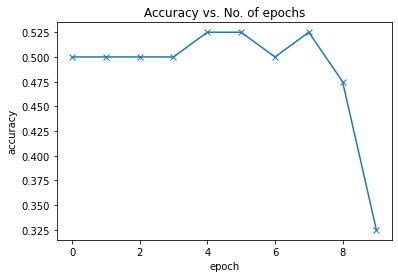

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

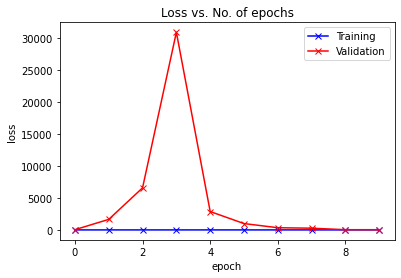

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

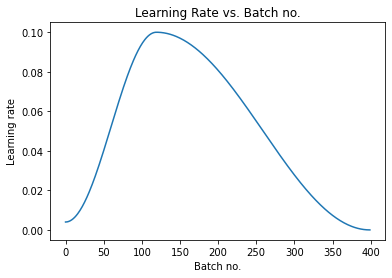

In [ ]:
plot_lrs(history)

In [ ]:
# if checkpoint_dir:
#         checkpoint = os.path.join(checkpoint_dir, "checkpoint")
#         model_state, optimizer_state = torch.load(checkpoint)
#         model.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)

# Running Inferences on the pre-trained networks and predicting actions

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!ls

drive  sample_data


In [ ]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import glob
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # python3 required

In [ ]:
os.chdir('drive/MyDrive/NNFL/kinetics400_tiny/kinetics400_tiny/')
# !unzip kinetics400_tiny.zip > /dev/null
# list_tiny_videos()

In [ ]:
with open('kinetics_tiny.txt') as f:
  lines = f.readlines()

csv = {}
for i in range(len(lines)):
  lines[i] = lines[i][:-1]
  temp = lines[i].split(' ')
  csv[temp[0]] = int(temp[1])

csv

{'0pVGiAU6XEA.mp4': 0,
 '27_CSXByd3s.mp4': 1,
 '34XczvTaRiI.mp4': 1,
 'A-wiliK50Zw.mp4': 1,
 'AQrbRSnRt8M.mp4': 1,
 'D32_1gwq35E.mp4': 0,
 'D92m0HsHjcQ.mp4': 0,
 'DbX8mPslRXg.mp4': 1,
 'FMlSTTpN3VY.mp4': 1,
 'IcLztCtvhb8.mp4': 1,
 'IyfILH9lBRo.mp4': 1,
 'LvcFDgCAXQs.mp4': 0,
 'O46YA8tI530.mp4': 0,
 'P5M-hAts7MQ.mp4': 0,
 'PnOe3GZRVX8.mp4': 1,
 'R8HXQkdgKWA.mp4': 0,
 'RqnKtCEoEcA.mp4': 0,
 'SU_x2LQqSLs.mp4': 0,
 'T_TMNGzVrDk.mp4': 1,
 'TkkZPZHbAKA.mp4': 0,
 'WWP5HZJsg-o.mp4': 1,
 'WaS0qwP46Us.mp4': 0,
 'Wh_YPQdH1Zg.mp4': 0,
 'ZQV4U2KQ370.mp4': 0,
 'b6Q_b7vgc7Q.mp4': 0,
 'ddvJ6-faICE.mp4': 1,
 'h10B9SVE-nk.mp4': 1,
 'h2YqqUhnR34.mp4': 0,
 'iRuyZSKhHRg.mp4': 1,
 'ik4BW3-SCts.mp4': 1,
 'jqRrH30V0k4.mp4': 0,
 'kFC3KY2bOP8.mp4': 1,
 'oMrZaozOvdQ.mp4': 1,
 'oXy-e_P_cAI.mp4': 0,
 'phDqGd0NKoo.mp4': 1,
 'soEcZZsBmDs.mp4': 1,
 'u4Rm6srmIS8.mp4': 0,
 'xGY2dP0YUjA.mp4': 0,
 'y5Iu7XkTqV0.mp4': 1,
 'yLC9CtWU5ws.mp4': 0}

In [ ]:
os.chdir('./train')

In [ ]:
def list_tiny_videos():
  """Lists videos available in UCF101 dataset."""
  _VIDEO_LIST = []
  if len(_VIDEO_LIST) == 0:
    parent_dir = ''
    videos = []
    for video_file in glob.glob(os.path.join(parent_dir, '*.mp4')):
      videos.append(video_file)


    _VIDEO_LIST = sorted(set(videos))

  return list(_VIDEO_LIST)

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [ ]:
# list_tiny_videos()
load_video(list_tiny_videos()[0]).shape

(300, 224, 224, 3)

In [ ]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [ ]:
# Get a sample video.
video_path = random.choice(list(csv.items()))[0]
sample_Video = load_video(video_path)

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [ ]:
def predict(sample_Video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_Video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
video_path = "0pVGiAU6XEA.mp4"

In [ ]:
sample_Video = load_video(video_path)[:90]
sample_Video.shape

(90, 224, 224, 3)


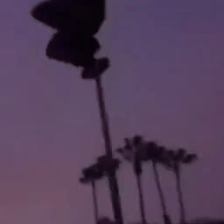

In [ ]:
to_gif(sample_Video)

In [ ]:
predict(sample_Video)

Top 5 actions:
  bungee jumping        : 55.65%
  climbing a rope       : 34.01%
  pole vault            :  2.32%
  abseiling             :  1.49%
  climbing tree         :  0.53%
